# Project roadmap and code

## Table of contents
1. [Questions](#1\.-Questions)
2. [Schedule](#2\.-Schedule)
3. [Documentation and first hands-on](#3\.-Documentation-and-first-hands-on)
4. [Data generation](#4\.-Data-generation)
5. [Data processing](#5\.-Data-processing)
6. [Machine learning](#6\.-Machine-learning)

## 1. Questions

Questions I wonder are grouped here:

- *In IGV usage*: **Question:** I'm not sure how to understand the vcf file in IGV, how do I know if it's an insertion or a deletion? Do the files I loaded correspond to one another? ✔️
- *In Data processing*: **Question:** Since we 'stream' data what's the best way to split train/test. Split certain positions? Split while iterating over batches? Train on chromosome 2, test on chromosome 1? ✔️
- *In Data processing*: **Question:** Some positions aren't found in the bedgraphs. Should put to 0 or -1 or another value?
- *In Data processing*: **Question:** Is window size 101 actually reasonable?
- *In Machine learning*: **Question:** How good are the results?

## 2. Schedule

### Week 1
- Meeting and get in touch with colleagues and Rick's work ✔️
- Download data and visualize with IGV ✔️
- Get in touch with formats (vcf, bam, ...) ✔️
- Read gnomAD paper ✔️

### Week 2
- Look at how they extract their features in the papers ✔️
- Extract data with Canevas from one genome of Genome in a Bottle ✔️
- Load data and pre-process it if needed ✔️
- Process data in python, vcf, signals data ✔️

### Week 3
- Check different approaches taken by papers to maybe take inspiration of window sizes or similar ✔️
- Filter VCF to event that pass filters ✔️
- Generate data by taking breakpoints of vcf and computing windows around them and windows with no events ✔️
- Split tain test ✔️
- Train model (deep net or random forest) ✔️

### Week 4
- Continue machine learning models
- Validate, compute performance

### Week 5
To be determined... (if work left, enough time, ...)

## 3. Documentation and first hands-on

This section will contain the steps done towards documentation, data exploration, IGV usage

### IGV usage

First, I downloaded [IGV 2.8.3](http://software.broadinstitute.org/software/igv/download) for Linux

Then I downloaded this data [here](ftp://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/NA12878/NA12878_PacBio_MtSinai/) from [Genome in a Bottle](https://www.nist.gov/programs-projects/genome-bottle):
- `NA12878.sorted.vcf.gz`
- `NA12878.sorted.vcf.gz.tbi`
- `README.txt`
- `merged_ec_output_primary.bam`
- `merged_ec_output_primary.bam.bai`

I tried to load `NA12878.sorted.vcf.gz` and `merged_ec_output_primary.bam` in IGV but there was a parsing error in the vcf file:
- I realized line 4 `#contig=<ID=chr1,...` was missing a `#` at the begginning
- I had to change the spaces in the header line to `\t`

I then was able to load the two files in IGV and have a visualization:

**Question:** I'm not sure how to understand the vcf file in IGV, how do I know if it's an insertion or a deletion? Do the files I loaded correspond to one another?

![IGV image](images/igv-NA12878-1.png)

## 4. Data generation

This section will contain the steps done towards data creation with [Canevas](https://github.com/rick-heig/canevas), different filters used

The `bam` file `merged_ec_output_primary.bam` I had was in long reads, thus it wasn't usable in Canevas and wasn't the format we want.

I asked the Genome Center for a short reads `bam` file on one chromosome and for now Rick gave me data generated with Canevas on `Guipponi.NA12878-A.mdup.sorted.bam.bqsr.bam` for chromosome 21 to start with

I then downloaded the `RMNISTHS_30xdownsample.bam` at ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/NA12878/NIST_NA12878_HG001_HiSeq_300x/ and extracted the features for chromosome 2, using Canevas and this very command:

`sbt run signal extract -b /home/lulu/Documents/Work/genome-center/data/RMNISTHS_30xdownsample.bam -o out -r 2`

## 5. Data processing

This section will contain the steps done towards data processing in order to use it in the machine learning pipeline

There is a *lot* of data, we can't load all signals for the whole chromosome at the same time.

When training, we have to get part of the data, train on it and get next chunk. Otherwise we won't have enough memory

To do that, I decided to go for an object-oriented approach, since I want the 'readers' to have states. I ask for the next batch and it returns it, keeping the next values already loaded.

That way later I should be able to load a batch of each signal, split the batch in mini_batches, train the model on them and then load the next batches.

I added MultiSignal to combine signals easily and get multiple batches.

Then I added a `SignalExtractor` for VCF, given a vcf file, when requested a batch it would say which positions were deleted. First I had a `np.vectorize` function to do that, similar to a map; that checked each position in the vcf file. But it was slow, so I changed to a broadcasting way where I utilize numpy's way of doing it, which greatly sped up running time.

**Version 2.0**:
After talking, we realized it was better to check positions with deletions, select positions with no deletions and get data for these points in order to generate data. Instead of reading all batches one by one to generate data. So we need to, given positions, retrieve signal's data. So a signal will take some positions and retrieve all the windows for these positions.


**Version 2.1**:
Version 2.0 was slow, using the `line_profiler` I analyzed the code to see the slow steps and reworked the code to have a fast bedgraph reader. (Some `line_profiler` output are presented in the next cells):
- Since by reading chunks we'll go through most of the bedgraph, it's better to give all positions at once, to go through the file only once
- Using skiprows is in fact very slow, it's way faster to use `TextFileReader` that has a `get_chunk` function. It's faster because it keeps the last position it was at, whereas skiprows goes through the file.
- Numpy is faster at retrieving specific values but pandas is convenient. So I use pandas and then use `.values` for crucial steps
- Binary search is faster than broadcasting to find the value for a pos
- Don't search for positions that aren't in chunk
- Parallelize signals reading

The `applymap` to fill in values used to take 99% of time, after all this reworking, reading is the slowest part of the algorithm. But the `TextFileReader` is by far the fastest way I've seen.

Some values aren't in the bedgraph, so I assume they are 0. Maybe should assume they are -1?

Window size of 100 seems reasonable according to [A Deep Learning Approach for Detecting Copy Number Variation in Next-Generation Sequencing Data](https://lulix.net/~lcerutti/notes2/notes/lcerutti/Notebook/yfxOvpdrvuQu/files/2019-A_Deep_Learning_Approach_for_Detecting_Copy_Number_Variation_in_Next-Generation_Sequencing_Data.pdf)

### Version 1 (deprecated)

In [1]:
%load_ext line_profiler

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pybedtools import BedTool

In [2]:
metadata_size = 3 # Number of metadata lines in bedgraph

chunk_size = 10000 # Number of lines read on bedgraph per iter
batch_size = 1000 # Number of values returned by SignalExtractor when asked for a batch

In [3]:
class SignalExtractor():
    def get_next_batch(self):
        raise NotImplementedError
        
    def has_next(self):
        raise NotImplementedError
        
    def reset(self):
        raise NotImplementedError

In [4]:
class SingleSignalExtractor(SignalExtractor):
    def __init__(self, bedgraph, data_dir='data/', metadata_size=metadata_size):
        self.bedgraph = BedTool(f'{data_dir}{bedgraph}')
        self.metadata_size = metadata_size
        self.skiprows = metadata_size # Remove metadata
        self.chunks_available = True
        self.batch_available = True
        self.remaining_values = np.array([])
        
        
    def get_next_batch(self):
        """
        Get next batch, which will have the `batch_size` next values. Can be smaller if there aren't enough values left
        """
        assert(self.has_next())
        
        if self.remaining_values.shape[0] >= batch_size:
            # There are enough values already read
            temp = self.remaining_values[:batch_size]
            self.remaining_values = self.remaining_values[batch_size:]
            return temp
        
        # Read next values
        df = self.bedgraph.to_dataframe(skiprows=self.skiprows, nrows=chunk_size)
        assert(df.isnull().sum().sum() == 0) # Check no missing values
        self.skiprows += len(df)
        
        # If there aren't as many rows as asked for, we are at the end of the file
        if len(df) < chunk_size:
            self.chunks_available = False
        
        # Repeat values the stated amount of time, since we want a continuous array of data
        df['repeat'] = df['end'] - df['start']
        df = df.drop(columns=['chrom', 'start', 'end'])
        df = df.reindex(df.index.repeat(df['repeat'])).reset_index(drop=True)
        df = df.drop(columns=['repeat'])
        
        # Put values in numpy and concatenate with previously loaded data
        values = df['name'].values
        values = np.concatenate([self.remaining_values, values])
        
        # Save remaining values and return batch
        self.remaining_values = values[batch_size:]
        
        self.batch_available = len(self.remaining_values) >= batch_size
        
        return values[:batch_size]
        
        
    def has_next(self):
        return self.chunks_available or self.batch_available
        
        
    def reset(self):
        self.skiprows = self.metadata_size
        self.chunks_available = True
        self.remaining_values = np.array([])

In [5]:
class MultiSignalExtractors(SignalExtractor):
    """
    Helper class to easily combine multiple signal extractors
    """
    def __init__(self, bedgraphs):
        self.signals = []
        
        for bedgraph in bedgraphs:
            if isinstance(bedgraph, SignalExtractor):
                self.signals.append(bedgraph)
            elif isinstance(bedgraph, str):
                self.signals.append(SingleSignalExtractor(bedgraph))
            else:
                raise ValueError
        
        
    def get_next_batch(self):
        """
        Get next batch for each signal and return them
        """
        batches = [signal.get_next_batch() for signal in self.signals]
        return np.stack(batches)
        
        
    def has_next(self):
        for signal in self.signals:
            if not signal.has_next():
                return False
        
        return True
        
        
    def reset(self):
        for signal in self.signals:
            signal.reset()

In [6]:
class VCFSignalExtractor(SignalExtractor):
    def __init__(self, vcf, data_dir='data/'):
        self.data = pd.read_table(f'{data_dir}{vcf}',
                                  skiprows=1,
                                  names=['chrom', 'pos', 'id', 'ref', 'alt', 'qual', 'filter', 'info', 'format', 'NA12878'],
                                  na_values='.')
    
        self.data = self.data[self.data['alt'] == '<DEL>'] # Only keep deletions
        self.data = self.data[self.data['filter'] == 'PASS'] # Only take variants that pass at least 3 filters
        self.data['end'] = self.data['info'].str.extract(r'^.*END=(\d+);.*$').astype(int)
        self.data = self.data.drop(columns=['id', 'ref', 'alt', 'qual', 'filter', 'info', 'format', 'NA12878'])
        self.data = self.data.rename(columns={'pos': 'start'})
        self.data = self.data.reset_index(drop=True)
                
        self.current_index = 0
        self.last_returned_pos = 0
        
    
    def _classify_batch(self, batch, requested_pos):
        """
        With broadcasting, check if positions are in-between a start-end pair or not and classify them
        All positions are >= 0, so while processing values >= 0 are not classified yet
            During computation:
            - `-2` means no deletion
            - `-1` means deletion
        """
        index = self.current_index
        while np.sum(batch >= 0) > 0:
            if index >= len(self.data):
                # No more data in vcf, so assume there are no deletions afterwards 
                batch[batch >= 0] = -2
            else:
                _, start, end = self.data.loc[index]
                
                # Before start, so if it wasn't classified yet, it's not deleted
                batch[(batch >= 0) & (batch < start)] = -2
                
                # Before end, so if it wasn't classified yet, it's between start and end -> deleted
                batch[(batch >= 0) & (batch < end)] = -1
                
                if end < requested_pos:
                    # Line is no longer needed, as we are further than it
                    self.current_index += 1
                
                index += 1
        
    
    def get_next_batch(self):
        requested_pos = self.last_returned_pos + batch_size
        
        if self.current_index >= len(self.data):
            # No more data in vcf, so assume there are no deletions afterwards
            self.last_returned_pos = requested_pos
            return np.zeros(batch_size)
        
        batch = np.arange(self.last_returned_pos, requested_pos)
        
        self._classify_batch(batch, requested_pos)
        
        # Convert temporary values used
        batch[batch == -2] = 0
        batch[batch == -1] = 1
        
        self.last_returned_pos = requested_pos
        return batch
        
        
    def has_next(self):
        # Always has_next since we assume that if there is no data left in vcf, there are no deletions
        return True
        
        
    def reset(self):
        self.current_index = 0
        self.last_returned_pos = 0

In [7]:
signals = [
    VCFSignalExtractor('NA12878.sorted.chr2.vcf'),
    '2_CigarIndels.bedgraph.gz',
    '2_Clipped.bedgraph.gz',
    '2_Coverage.bedgraph.gz',
    '2_DiscordantTandemOrientation.bedgraph.gz',
    '2_ForwardInsertSizeTooBig.bedgraph.gz',
    '2_InsertSizeTooBig.bedgraph.gz',
    '2_InsertSizeTooSmall.bedgraph.gz',
    '2_InterChr.bedgraph.gz',
    '2_MappingErrors.bedgraph.gz',
    '2_MAPQ0.bedgraph.gz',
    '2_MateUnmapped.bedgraph.gz'
]

signal_extractor = MultiSignalExtractors(signals)

In [8]:
%%time

batch = np.zeros((len(signals), batch_size))

while np.sum(batch[0, :]) == 0: # Iterate until we have a deletion
    batch = signal_extractor.get_next_batch()

CPU times: user 2.11 s, sys: 460 ms, total: 2.57 s
Wall time: 2.59 s


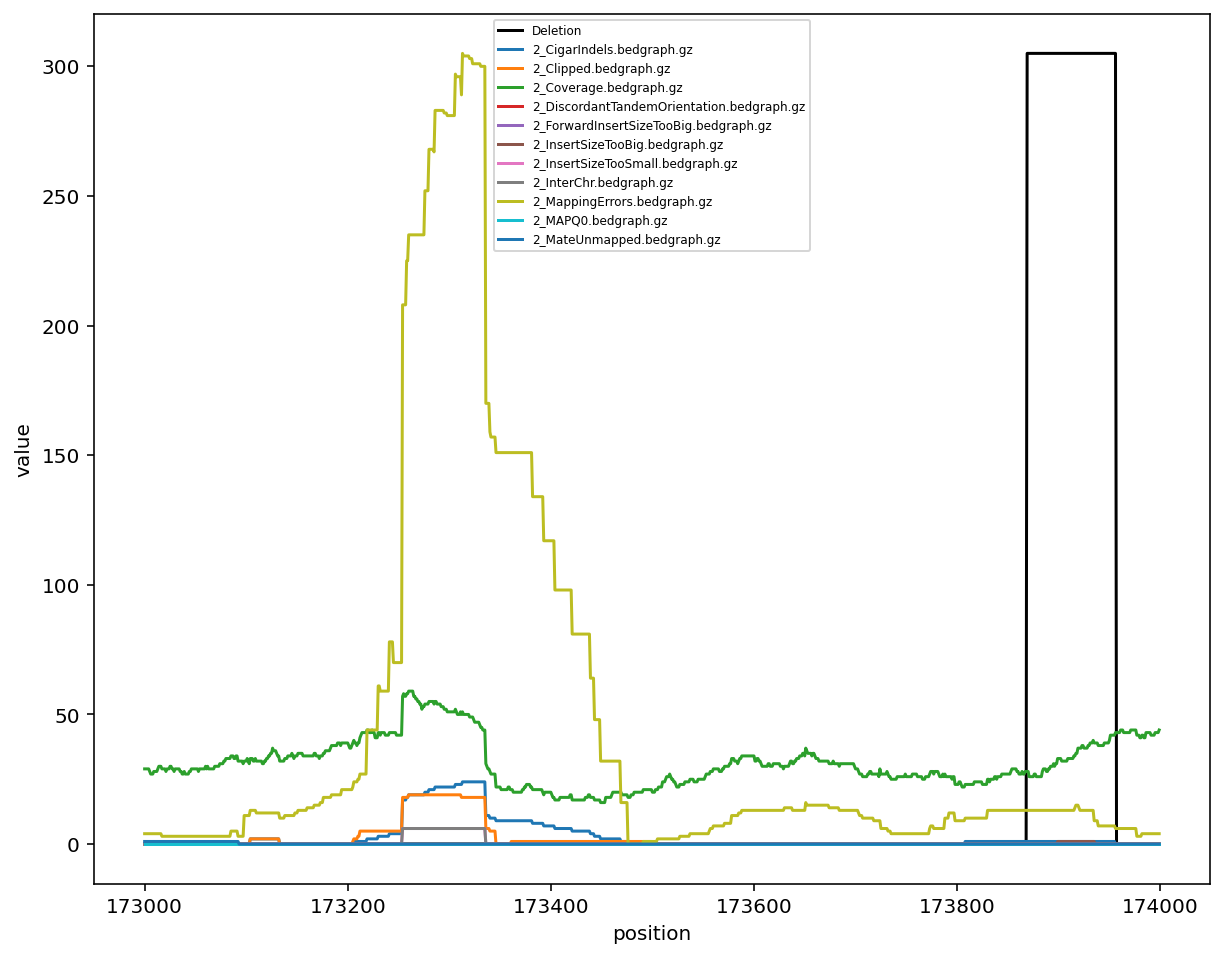

In [9]:
plt.figure(figsize=(10, 8), dpi=144)

x = np.arange(-batch_size, 0) + signals[0].last_returned_pos

plt.plot(x, batch[0]*np.max(batch), label='Deletion', color='black')


for i, signal in enumerate(batch[1:]):
    name = signals[i+1]
    plt.plot(x, signal, label=name)
    
plt.xlabel('position')
plt.ylabel('value')
plt.legend(fontsize=6)
plt.show()

### Version 2.0 (deprecated)

In [111]:
class SingleSignalExtractor(SignalExtractor):
    def __init__(self, bedgraph, data_dir='data/', chunk_size=100, metadata_size=metadata_size):
        self.bedgraph = BedTool(f'{data_dir}{bedgraph}')
        self.metadata_size = metadata_size
        self.chunk_size = chunk_size
        self.data = 
        
        
    def _pos_in_df(self, df, pos):
        return ((df['start'] <= pos) &
                (df['end'] >= pos))
        
        
    def get_window(self, pos):
        """
        Get next batch, which will have the `batch_size` next values. Can be smaller if there aren't enough values left
        """
        start, end = get_start_end_window(pos)
        
        skiprows = self.metadata_size
        nrows = self.chunk_size
        
        # Search start
        while True:
            print(skiprows, nrows)
            df = self.bedgraph.to_dataframe(skiprows=skiprows, nrows=nrows)
            if len(df) == 0:
                skiprows -= int(step/2)
            else:
                in_range = self._pos_in_df(df, start)
                if in_range.sum() > 0:
                    break

                chunk_start = df['start'].values[0]
                line_average_size = (df['end'] - df['start']).mean()

                too_far = chunk_start > start

                step = int(abs(start - chunk_start) / line_average_size)
                step = max(nrows, step)

                if too_far:
                    step = -step

                skiprows += step
            
        skiprows += np.argmax(in_range.values) # Go to start
        
        # Search end
        while not (in_range := self._pos_in_df(self.bedgraph.to_dataframe(skiprows=skiprows,\
                                                                          nrows=nrows,\
                                                                          usecols=['start', 'end']), end)).sum() > 0:
            nrows += nrows
            
        
        nrows = np.argmax(in_range.values)+1 # Go until end
        
        df = self.bedgraph.to_dataframe(skiprows=skiprows, nrows=nrows, usecols=['start', 'end', 'name'])
        
        assert(df.isnull().sum().sum() == 0) # Check no missing values
        
        window = np.arange(start, end+1)
        
        for i, row in df.iterrows():
            row_start = row['start']
            row_end = row['end']
            row_value = row['name']
            
            window[(window >= row_start) & (window <= row_end)] = -row_value
        
        window = -window
        
        return window

In [112]:
%lprun -f SingleSignalExtractor.get_window SingleSignalExtractor('2_MappingErrors.bedgraph.gz').get_window(20000000)

3 100
1741283 100
1855667 100
1939816 100
1955050 100
1952886 100
1952708 100


Timer unit: 1e-06 s

Total time: 2.32161 s
File: <ipython-input-111-b571b325cab2>
Function: get_window at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                               def get_window(self, pos):
    14                                                   """
    15                                                   Get next batch, which will have the `batch_size` next values. Can be smaller if there aren't enough values left
    16                                                   """
    17         1          5.0      5.0      0.0          start, end = get_start_end_window(pos)
    18                                                   
    19         1          1.0      1.0      0.0          skiprows = self.metadata_size
    20         1          1.0      1.0      0.0          nrows = self.chunk_size
    21                                                   
    22                                                   # Search start

### Version 2.1

In [1]:
%load_ext line_profiler
%load_ext autoreload

%autoreload 2

import time
from collections import defaultdict
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pybedtools import BedTool
from sklearn.model_selection import train_test_split

In [2]:
def get_length_chrom(chrom):
    return pd.read_table(f'data/NA12878.sorted.chr{chrom}.vcf', nrows=1, header=None)[0]\
             .str.extract(r'^.*length=(\d+),.*$', expand=False).astype(int).values[0]

In [3]:
metadata_size = 3 # Number of metadata lines in bedgraph
length_chrom_2 = get_length_chrom(2)

window_size = 101
assert(window_size >= 3 and window_size % 2 == 1) # Check odd number

In [4]:
def get_start_end_window(pos):
    start = pos - (window_size-1)/2
    end = pos + (window_size-1)/2
    return start, end

In [5]:
class SignalExtractor():
    def get_windows(self, positions):
        raise NotImplementedError

In [6]:
class SingleSignalExtractor(SignalExtractor):
    def __init__(self, bedgraph, data_dir='data/', metadata_size=metadata_size, chunk_size=1000000):
        self.bedgraph = BedTool(f'{data_dir}{bedgraph}')
        self.metadata_size = metadata_size
        self.name = bedgraph[2:].split('.')[0]
        
        self.chunk_size = chunk_size
        self.last_chunk_size = chunk_size
        
        self.dict = defaultdict(lambda: None)
        
    
    def _print_progress(self, progress):
        print(f"Signal {self.name} {progress:.1f}% complete")
        
        
    def _pos_in_df(self, values, pos):        
        left = 0
        right = values.shape[0] - 1        
        
        while left <= right:
            mid = int((right - left) / 2) + left            
            
            start = values[mid, 0]
            end = values[mid, 1]
            
            if start <= pos and pos <= end:
                return mid
            elif end <= pos:
                if left == mid:
                    mid += 1
                left = mid
            elif start >= pos:
                if right == mid:
                    mid -= 1
                right = mid
            else:
                raise ValueError
        
        return None
    
    
    def _fill_value(self, pos, chunk_values):        
        if pos <= 0:
            return pos
        
        start_chunk = chunk_values[0, 0]
        end_chunk = chunk_values[-1, 1]
        
        if pos < start_chunk or pos > end_chunk:
            # pos not in chunk
            return pos
        
        value = self.dict[pos]
        
        if value != None:
            return value
        
        index = self._pos_in_df(chunk_values, pos)
        
        if index == None:
            return 0 # Value not in bedgraph -> assume 0
        
        row = chunk_values[index]
        
        start = row[0]
        end = row[1]
        value = -row[2]

        for i in range(start, end+1):
            self.dict[i] = value

        return value
        
        
    def get_windows(self, positions, prefix_str=""):
        """
        Get next batch, which will have the `batch_size` next values. Can be smaller if there aren't enough values left
        """
        file_reader = self.bedgraph.to_dataframe(iterator=True, skiprows=3, chunksize=self.chunk_size, usecols=['start', 'end', 'name'])
        
        windows = np.empty((len(positions), window_size))
        starts, ends = get_start_end_window(positions)
        
        for i in range(len(positions)):
            windows[i] = np.arange(starts[i], ends[i]+1)
            
        
        number_values = windows.size
        windows = pd.DataFrame(windows)
        
        progress = 0
        self._print_progress(progress)
        
        number_values_left = number_values
            
        
        while number_values_left > 0:
            chunk = file_reader.get_chunk()
            chunk_values = chunk.values
            
            windows = windows.applymap(lambda pos: self._fill_value(pos, chunk_values))
            
            number_values_left = (windows > 0).sum().sum()
            
            new_progress = (1 - number_values_left / number_values) * 100.0
            if new_progress > progress:
                progress = new_progress
                self._print_progress(progress)
            
                    
        return -windows

In [7]:
%lprun -f SingleSignalExtractor.get_windows SingleSignalExtractor('2_Coverage.bedgraph.gz').get_windows(np.array([100000, 1230123, 12312314, 1435456, 43765, 6575756, 45546, 4735734]))

Signal Coverage 0.0% complete
Signal Coverage 62.5% complete
Signal Coverage 75.0% complete
Signal Coverage 87.5% complete
Signal Coverage 100.0% complete


Timer unit: 1e-06 s

Total time: 1.46744 s
File: <ipython-input-6-2cde1a871c44>
Function: get_windows at line 76

Line #      Hits         Time  Per Hit   % Time  Line Contents
    76                                               def get_windows(self, positions, prefix_str=""):
    77                                                   """
    78                                                   Get next batch, which will have the `batch_size` next values. Can be smaller if there aren't enough values left
    79                                                   """
    80         1       6396.0   6396.0      0.4          file_reader = self.bedgraph.to_dataframe(iterator=True, skiprows=3, chunksize=self.chunk_size, usecols=['start', 'end', 'name'])
    81                                                   
    82         1         17.0     17.0      0.0          windows = np.empty((len(positions), window_size))
    83         1         49.0     49.0      0.0          starts, ends = get_sta

In [8]:
%lprun -f SingleSignalExtractor._fill_value SingleSignalExtractor('2_CigarIndels.bedgraph.gz').get_windows(np.array([100000, 1230123, 12312314, 1435456, 43765, 6575756, 45546, 4735734]))

Signal CigarIndels 0.0% complete
Signal CigarIndels 100.0% complete


Timer unit: 1e-06 s

Total time: 0.015822 s
File: <ipython-input-6-2cde1a871c44>
Function: _fill_value at line 43

Line #      Hits         Time  Per Hit   % Time  Line Contents
    43                                               def _fill_value(self, pos, chunk_values):        
    44       816        468.0      0.6      3.0          if pos <= 0:
    45                                                       return pos
    46                                                   
    47       816        498.0      0.6      3.1          start_chunk = chunk_values[0, 0]
    48       816        406.0      0.5      2.6          end_chunk = chunk_values[-1, 1]
    49                                                   
    50       816       3297.0      4.0     20.8          if pos < start_chunk or pos > end_chunk:
    51                                                       # pos not in chunk
    52                                                       return pos
    53                          

In [9]:
%lprun -f SingleSignalExtractor._pos_in_df SingleSignalExtractor('2_MappingErrors.bedgraph.gz').get_windows(np.array([100000, 1230123, 12312314, 1435456, 43765, 6575756, 45546, 4735734]))

Signal MappingErrors 0.0% complete
Signal MappingErrors 87.5% complete
Signal MappingErrors 100.0% complete


Timer unit: 1e-06 s

Total time: 0.008644 s
File: <ipython-input-6-2cde1a871c44>
Function: _pos_in_df at line 17

Line #      Hits         Time  Per Hit   % Time  Line Contents
    17                                               def _pos_in_df(self, values, pos):        
    18        60         51.0      0.8      0.6          left = 0
    19        60         53.0      0.9      0.6          right = values.shape[0] - 1        
    20                                                   
    21      1138        368.0      0.3      4.3          while left <= right:
    22      1138        625.0      0.5      7.2              mid = int((right - left) / 2) + left            
    23                                                       
    24      1138        629.0      0.6      7.3              start = values[mid, 0]
    25      1138        561.0      0.5      6.5              end = values[mid, 1]
    26                                                       
    27      1138       2718.0   

In [10]:
def init_signals(signals):
    signals_ = []
    
    for signal in signals:
        if isinstance(signal, SignalExtractor):
            signals_.append(signal)
        elif isinstance(signal, str):
            signals_.append(SingleSignalExtractor(signal))
        else:
            raise ValueError
            
    return signals_

In [11]:
class MultiSignalExtractors(SignalExtractor):
    """
    Helper class to easily combine multiple signal extractors
    Uses constant global array SIGNALS as signals
    """
    def _compute_windows(args):
        i = args[0]
        positions = args[1]
        signal = SIGNALS[i]
        
        windows = signal.get_windows(positions)
        
        return windows.values
        
        
    def get_windows(self, positions):
        """
        Get next batch for each signal and return them
        """
        n_signals = len(SIGNALS)
        pool = multiprocessing.Pool(n_signals)
        windows = np.array(pool.map(MultiSignalExtractors._compute_windows, [(i, positions) for i in range(n_signals)]))
        pool.close()
        pool.join()
        
        return windows.reshape(len(positions), len(SIGNALS), window_size)

In [12]:
class VCFSignal():
    def __init__(self, vcf, length_chrom, data_dir='data/', seed=13):
        self.seed = seed
        self.length_chrom = length_chrom
        
        self.data = pd.read_table(f'{data_dir}{vcf}',
                                  skiprows=1,
                                  names=['chrom', 'pos', 'id', 'ref', 'alt', 'qual', 'filter', 'info', 'format', 'NA12878'],
                                  na_values='.')
    
        self.data = self.data[self.data['alt'] == '<DEL>'] # Only keep deletions
        self.data = self.data[self.data['filter'] == 'PASS'] # Only take variants that pass at least 3 filters
        self.data['end'] = self.data['info'].str.extract(r'^.*END=(\d+);.*$').astype(int)
        self.data = self.data.drop(columns=['chrom', 'id', 'ref', 'alt', 'qual', 'filter', 'info', 'format', 'NA12878'])
        self.data = self.data.rename(columns={'pos': 'start'})
        self.data = self.data.reset_index(drop=True)
        
    
    def get_window_positions(self, scale_not_breakpoint=1):
        """
        Get batch positions for deletions and not deletions
        
        :scale_not_breakpoint:: Ratio between not deletions and deletions
        """
        np.random.seed(self.seed)
        
        delete_positions = self.data.values.reshape(-1)
        np.random.shuffle(delete_positions)
        
        not_delete_positions = []
        
        number_deletes = delete_positions.shape[0]
        number_not_deletes = int(scale_not_breakpoint * number_deletes)
        
        while len(not_delete_positions) < number_not_deletes:
            pos = np.random.randint(0, self.length_chrom - (window_size-1)/2) # TODO: change magic number (beginning and end of chrom)
            
            start, end = get_start_end_window(pos)
            
            overlaps_with_delete = (((start <= self.data['start']) & (self.data['start'] <= end)) | # Start in window
                                    ((self.data['start'] <= start) & (end <= self.data['end'])) | # Contains window
                                    ((start <= self.data['start']) & (self.data['end'] <= end)) | # Inside window
                                    ((start <= self.data['end']) & (self.data['end'] <= end)) # End in window
                                   ).sum() > 0
            
            if not overlaps_with_delete:
                not_delete_positions.append(pos)
                
        
        return np.array(not_delete_positions), delete_positions

In [13]:
vcfSignal = VCFSignal('NA12878.sorted.chr2.vcf', length_chrom_2)
not_delete_positions, delete_positions = vcfSignal.get_window_positions()
all_positions = np.concatenate((delete_positions, not_delete_positions))

In [14]:
SIGNALS = init_signals([
    '2_CigarIndels.bedgraph.gz',
    '2_Clipped.bedgraph.gz',
    '2_Coverage.bedgraph.gz',
    '2_DiscordantTandemOrientation.bedgraph.gz',
    '2_ForwardInsertSizeTooBig.bedgraph.gz',
    '2_InsertSizeTooBig.bedgraph.gz',
    '2_InsertSizeTooSmall.bedgraph.gz',
    '2_InterChr.bedgraph.gz',
    '2_MappingErrors.bedgraph.gz',
    '2_MAPQ0.bedgraph.gz',
    '2_MateUnmapped.bedgraph.gz'
])

signal_extractor = MultiSignalExtractors()

In [15]:
%%time
data = signal_extractor.get_windows(all_positions)

Signal InsertSizeTooSmall 0.0% complete
Signal InterChr 0.0% complete
Signal Clipped 0.0% complete
Signal Coverage 0.0% complete
Signal DiscordantTandemOrientation 0.0% complete
Signal CigarIndels 0.0% complete
Signal InsertSizeTooBig 0.0% complete
Signal ForwardInsertSizeTooBig 0.0% complete
Signal MappingErrors 0.0% complete
Signal MateUnmapped 0.0% complete
Signal MAPQ0 0.0% complete
Signal Coverage 3.1% complete
Signal MappingErrors 6.6% complete
Signal Clipped 39.3% complete
Signal CigarIndels 34.7% complete
Signal Coverage 5.4% complete
Signal InsertSizeTooSmall 100.0% complete
Signal MateUnmapped 100.0% complete
Signal InterChr 100.0% complete
Signal InsertSizeTooBig 100.0% complete
Signal MappingErrors 11.2% complete
Signal Clipped 82.3% complete
Signal MAPQ0 46.7% complete
Signal ForwardInsertSizeTooBig 100.0% complete
Signal Coverage 6.3% complete
Signal CigarIndels 69.3% complete
Signal Clipped 100.0% complete
Signal MappingErrors 14.8% complete
Signal Coverage 8.0% complete

As we can see, the computation time makes sense, `Coverage` is the most complicated signal, followed by `MappingErrors`

In [16]:
X = data.reshape(all_positions.shape[0], -1)
y = np.zeros(all_positions.shape[0])
y[np.arange(delete_positions.shape[0])] = 1 # First positions are delete_positions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 6. Machine learning

## First idea
- Multiple Conv1d on each signal separately (maybe could use Conv2d for faster execution time, if implemented carefully, kernel of dim 1-x to treat signals differently)
- Then combine all signals and make a decision (2 dimensions, 1 hot encoded) with a few linear layers
- Since I don't have the whole data at one time, I can't really standardize homogeneously, which may be a proble
- To stabilize and fasten training I could make use of batch normalization
- I may also look at dropout, in order to have a model that generalizes better

How should the output be?
1. Give it a window of size 51 for example and it says if the middle value 26 is a deletion or not?
2. Give a window of size x returns x binary outputs

First may be simpler to train

We might have an issue because of the hugely unbalanced classes, deep nets usually avoid this issue but it may be a problem here. Maybe have a special loss where missclassifying a deletion is a huge error compared to missclassifying a not-deletion.

## Second idea

Train random forest on processed data

Find best hyperparameters using cross-validation on f1-score then show results for test set

Hyperparameters:
- `max_depth` is clearly better for `None` so no need to search one
- `criterion` gini or entropy
- `max_features` sqrt(2) or log2, the number of features to consider when looking for the best split
- `min_impurity_decrease`
- `min_samples_split` the minimum number of samples required to split an internal node
- `min_samples_leaf` the minimum number of samples required to be at a leaf node
- `n_estimators` the number of trees in the forest
- Since the classes are balanced, no need to tune `class_weight`

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

from source.confusion_matrix_pretty_print import pretty_plot_confusion_matrix

In [18]:
n_jobs = 8
random_state = 42

In [19]:
def show_metrics(target, pred):
    conf_mat = confusion_matrix(target, pred, labels=[1, 0])
    conf_mat = pd.DataFrame(conf_mat, columns = ['Deleted', 'Not deleted'], index = ['Deleted', 'Not deleted'])

    acc = accuracy_score(target, pred)
    precision = precision_score(target, pred)
    recall = recall_score(target, pred)
    f1 = f1_score(target, pred)
    
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall: {recall*100:.2f}%")
    print(f"F1: {f1*100:.2f}%")
    
    pretty_plot_confusion_matrix(conf_mat)

In [20]:
def hyperparameter_grid_score(criterions, max_features_, min_impurity_decreases, min_samples_splits, min_samples_leaves, n_estimators_, n_jobs=n_jobs, scorer=make_scorer(f1_score), random_state=random_state):
    scores = []
    params = []
    
    number_steps = len(criterions) * len(max_features_) * len(min_impurity_decreases) * len(min_samples_splits) * len(min_samples_leaves) * len(n_estimators_)
    step = 0
    progress = -1
    
    for criterion in criterions:
        for max_features in max_features_:
            for min_impurity_decrease in min_impurity_decreases:
                for min_samples_split in min_samples_splits:
                    for min_samples_leaf in min_samples_leaves:
                        for n_estimators in n_estimators_:
                            clf = RandomForestClassifier(criterion=criterion,\
                                                         max_features=max_features,\
                                                         min_impurity_decrease=min_impurity_decrease,\
                                                         min_samples_split=min_samples_split,\
                                                         min_samples_leaf=min_samples_leaf,\
                                                         n_estimators=n_estimators,\
                                                         n_jobs=n_jobs,\
                                                         random_state=random_state)

                            cv_score = np.mean(cross_val_score(clf, X_train, y_train, scoring=scorer, n_jobs=n_jobs))

                            params.append((criterion, max_features, min_impurity_decrease, min_samples_split, min_samples_leaf, n_estimators))
                            scores.append(cv_score)

                            step += 1
                            new_progress = int(step/number_steps*100)
                            if new_progress > progress:
                                progress = new_progress
                                print(f"\rProgress: {progress}%", end='')
                            
    best_score = np.argmax(scores)
    best_params = params[best_score]
    
    best_criterion = best_params[0]
    best_max_features = best_params[1]
    best_min_impurity_decrease = best_params[2]
    best_min_samples_split = best_params[3]
    best_min_samples_leaf = best_params[4]
    best_n_estimators = best_params[5]
    
    print(f"\n\nBest criterion: {best_criterion}")
    print(f"Best max_features: {best_max_features}")
    print(f"Best min_impurity_decrease: {best_min_impurity_decrease}")
    print(f"Best min_samples_split: {best_min_samples_split}")
    print(f"Best min_samples_leaf: {best_min_samples_leaf}")
    print(f"Best n_estimators: {best_n_estimators}")
    
    return best_criterion, best_max_features, best_min_impurity_decrease, best_min_samples_split, best_min_samples_leaf, best_n_estimators

##### Search best hyperparameters

In [21]:
%%time

criterions = ['gini', 'entropy']
max_features = ['sqrt', 'log2']
min_impurity_decreases = np.linspace(0, 0.0003, 4)
min_samples_splits = np.linspace(2, 20, 5, dtype=int)
min_samples_leaves = np.linspace(1, 2, 2, dtype=int)
n_estimators = np.linspace(100, 1000, 5, dtype=int)

best_criterion, best_max_features, best_min_impurity_decrease, best_min_samples_split, best_min_samples_leaf, best_n_estimators = hyperparameter_grid_score(
                                                                                                                                    criterions,\
                                                                                                                                    max_features,\
                                                                                                                                    min_impurity_decreases,\
                                                                                                                                    min_samples_splits,\
                                                                                                                                    min_samples_leaves,\
                                                                                                                                    n_estimators)

Progress: 100%

Best criterion: entropy
Best max_features: log2
Best min_impurity_decrease: 0.00019999999999999998
Best min_samples_split: 15
Best min_samples_leaf: 1
Best n_estimators: 775
CPU times: user 6.05 s, sys: 3.14 s, total: 9.19 s
Wall time: 46min


##### Search best hyperparameters around previously found hyperparameters

In [24]:
%%time

min_samples_splits = np.linspace(best_min_samples_split-2, best_min_samples_split+2, 5, dtype=int)
min_samples_leaves = np.linspace(1, 2, 2, dtype=int)
n_estimators = np.linspace(best_n_estimators-100, best_n_estimators+100, 21, dtype=int)

best_criterion_final, best_max_features_final, best_min_impurity_decrease_final, best_min_samples_split_final, best_min_samples_leaf_final, best_n_estimators_final = hyperparameter_grid_score(
                                                                                                                                                                        [best_criterion],\
                                                                                                                                                                        [best_max_features],\
                                                                                                                                                                        [best_min_impurity_decrease],\
                                                                                                                                                                        min_samples_splits,\
                                                                                                                                                                        min_samples_leaves,\
                                                                                                                                                                        n_estimators)

Progress: 100%

Best criterion: entropy
Best max_features: log2
Best min_impurity_decrease: 0.00019999999999999998
Best min_samples_split: 15
Best min_samples_leaf: 1
Best n_estimators: 795
CPU times: user 1.65 s, sys: 811 ms, total: 2.46 s
Wall time: 12min 57s


##### Show metrics

Training metrics:
Accuracy: 89.59%
Precision: 86.95%
Recall: 93.02%
F1: 89.88%


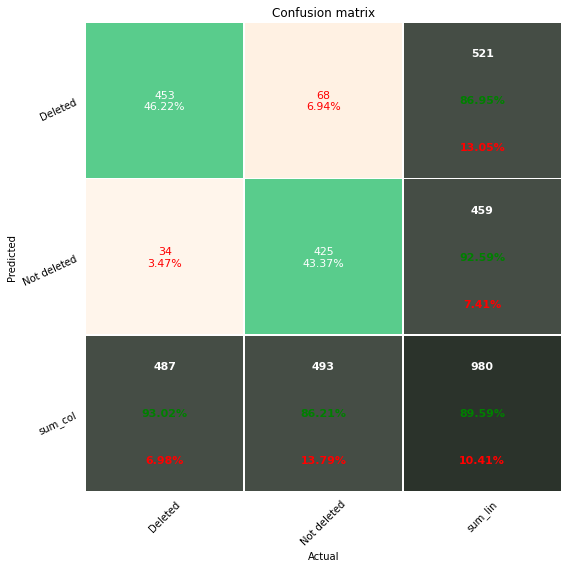



Test metrics:
Accuracy: 67.77%
Precision: 66.42%
Recall: 73.47%
F1: 69.77%


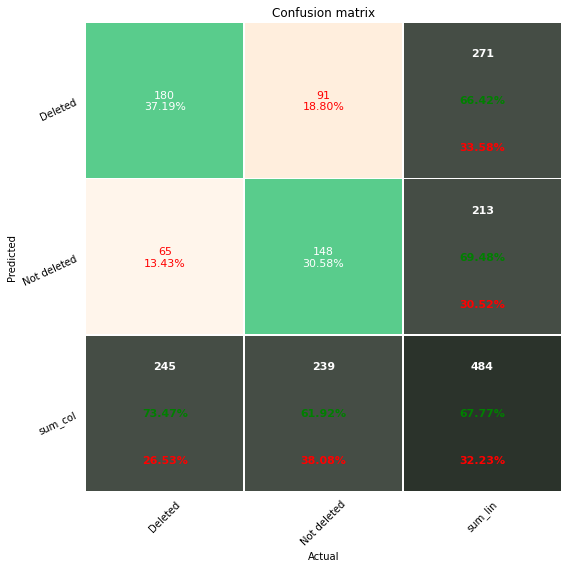

In [25]:
clf = RandomForestClassifier(criterion=best_criterion_final,\
                             max_features=best_max_features_final,\
                             min_impurity_decrease=best_min_impurity_decrease_final,\
                             min_samples_split=best_min_samples_split_final,\
                             min_samples_leaf=best_min_samples_leaf_final,\
                             n_estimators=best_n_estimators_final,\
                             n_jobs=n_jobs,\
                             random_state=random_state)

clf.fit(X_train, y_train)

print("Training metrics:")
pred_train = clf.predict(X_train)
show_metrics(y_train, pred_train)

print("\n\nTest metrics:")
pred_test = clf.predict(X_test)
show_metrics(y_test, pred_test)

The results seem good compared to simple filters, comparing to metrics from different softwares reported in Rick's report.